# Семинар 7
# Распознавание образов
# Курс "Компьютерное зрение"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt
from math import sqrt, exp, pi
from scipy.stats import norm
from matplotlib.colors import ListedColormap

from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from scipy import stats

import cv2
import os

from skimage.color import rgb2gray

from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)

from skimage import io

# I. Общее рассмотрение базовых алгоритмов машинного обучения
## 1. Изучение алгоритма классификации на основе метода линейного дискриминантного анализа
## 1.1. Генерация данных
Для двух классов условные вероятности данных в каждом из классов подчиняются двумерному нормальному распределению с параметрами:
- первый класс: среднее значение = [1; 3], СКО = [0,7; 0,8], коэффициент корреляции = 0,2.
- второй класс: среднее значение = [3;2], СКО = [0,3; 1,8], коэффициент корреляции = 0,7.

При расчете принять априорные вероятности классов одинаковыми.

Для первого класса:

In [2]:
# First class parameters
N_train = 6000 # Number of samples in training set
N_test = 2000 # Number of samples in testing set
mean_1 = np.array([1, 3]) # Mean value
std_1 = np.array([0.7, 0.8]) # Standard deviation
cor_coef_1 = 0.2 # Correlation coefficient
prob_1 = 0.5 # Class 1 prior probability
# Correlation matrix
sigma_1 = np.array([[std_1[0]**2, cor_coef_1*std_1[0]*std_1[1]],
                         [cor_coef_1*std_1[0]*std_1[1], std_1[1]**2]])

In [3]:
train_data_1 = np.random.multivariate_normal(mean_1, sigma_1, size=N_train)
test_data_1 = np.random.multivariate_normal(mean_1, sigma_1, size=N_test)

Для второго класса:

In [4]:
# Second class parameters
N_train = 6000 # Number of samples in training set
N_test = 2000 # Number of samples in testing set
mean_2 = np.array([3, 2]) # Mean value
std_2 = np.array([0.3, 1.8]) # Standard deviation
cor_coef_2 = 0.7 # Correlation coefficient
prob_2 = 0.5 # Class 2 prior probability
# Correlation matrix
sigma_2 = np.array([[std_2[0]**2, cor_coef_2*std_2[0]*std_2[1]],
                         [cor_coef_2*std_2[0]*std_2[1], std_2[1]**2]])

In [5]:
train_data_2 = np.random.multivariate_normal(mean_2, sigma_2, size=N_train)
test_data_2 = np.random.multivariate_normal(mean_2, sigma_2, size=N_test)

Построим классы на плоскости исходного пространства

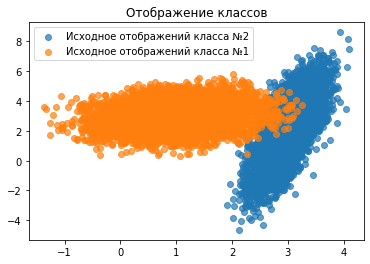

In [6]:
plt.scatter(train_data_2[:,0], train_data_2[:,1], label='Исходное отображений класса №2', alpha=0.7)
plt.scatter(train_data_1[:,0], train_data_1[:,1], label='Исходное отображений класса №1', alpha=0.7)
plt.title("Отображение классов")
plt.legend()
plt.show()

## 1.2 По группе обучения выполнить расчет проекционного вектора методом ЛДА
Расчет матриц внутриклассовых разбросов и общей матрицы внутриклассового разброса.

In [7]:
Sw1 = (N_train -1)*np.cov(train_data_1.T)
Sw2 = (N_train -1)*np.cov(train_data_2.T)
Sw = Sw1 + Sw2

Расчет вектора перехода

In [8]:
W = np.dot(np.linalg.inv(Sw),(mean_1 - mean_2).T)

Определение коэффициентов прямой

In [9]:
Y1 = W.T*train_data_1
Y2 = W.T*train_data_2
b = W[1]/W[0]
X = np.append(train_data_1[:,0], train_data_2[:,0])
Y = np.append(train_data_1[:,1], train_data_2[:,1])
a = np.mean(Y) - b*np.mean(X)

Построение разделяющей прямой

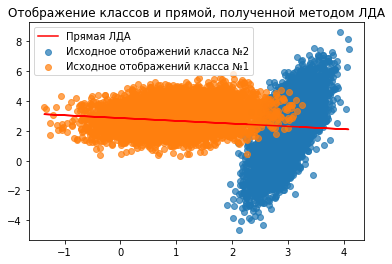

In [10]:
Y_devide = a+b*X
plt.scatter(train_data_2[:,0], train_data_2[:,1], label='Исходное отображений класса №2', alpha=0.7)
plt.scatter(train_data_1[:,0], train_data_1[:,1], label='Исходное отображений класса №1', alpha=0.7)
plt.plot(X,Y_devide, label='Прямая ЛДА', c="r")
plt.title("Отображение классов и прямой, полученной методом ЛДА")
plt.legend()
plt.show()

## 1.3. Спроецировать данные из группы обучения на построенный вектор и определить пороговое значение, для которого суммарная частота ошибочной классификации будет минимальна
Проекция данных в новое подпространство и расчет новых параметров распределения признаков

In [11]:
# Distribution parameters in the new space
mean_new_1 = np.dot(W.T, mean_1)
mean_new_2 = np.dot(W.T, mean_2)

sigma_new_1 = np.linalg.multi_dot([W.T, sigma_1, W])
sigma_new_2 = np.linalg.multi_dot([W.T, sigma_2, W])

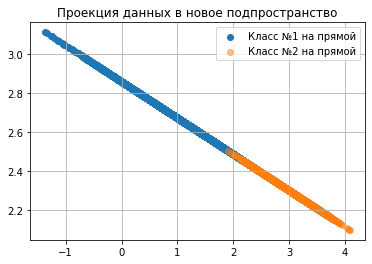

In [12]:
y1 = a+b*train_data_1[:,0]
y2 = a+b*train_data_2[:,0]

plt.scatter(train_data_1[:,0],y1, label='Класс №1 на прямой', alpha=1)
plt.scatter(train_data_2[:,0],y2, label='Класс №2 на прямой', alpha=0.5)
plt.title("Проекция данных в новое подпространство")
plt.legend()
plt.grid()
plt.show()

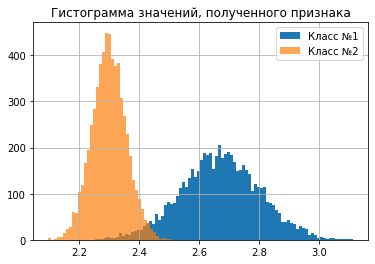

In [13]:
binwidth = 0.01
plt.hist(y1, bins=np.arange(min(y1), max(y1) + binwidth, binwidth), label='Класс №1', alpha=1.0)
plt.hist(y2, bins=np.arange(min(y2), max(y2) + binwidth, binwidth), label='Класс №2', alpha=0.7)
plt.title("Гистограмма значений, полученного признака")
plt.legend()
plt.grid()
plt.show()

Определим пороговое значение y_thr_new

In [14]:
# Calculate histograms
y1_hist = np.histogram(y1, bins=np.arange(min(y1), max(y1) + binwidth, binwidth))
y2_hist = np.histogram(y2, bins=np.arange(min(y2), max(y2) + binwidth, binwidth))

# Find peaks of histograms
y1_max = max(y1_hist[0])
y2_max = max(y2_hist[0])

# Find location of peaks
y1_max_coord = y1_hist[1][np.argwhere(y1_hist[0]==y1_max)[0][0]]
y2_max_coord = y2_hist[1][np.argwhere(y2_hist[0]==y2_max)[0][0]]

In [15]:
print("Максимальные значения на гистограмме:\nДля первого класса:", y1_max, " достигается при ", y1_max_coord,
      "\nДля второго класса:", y2_max, " достигается при ", y2_max_coord,)

Максимальные значения на гистограмме:
Для первого класса: 205  достигается при  2.662941747799998 
Для второго класса: 449  достигается при  2.2864529301545633


Создать набор порогов

In [16]:
threshold_range = np.arange(y2_max_coord, y1_max_coord, 0.01)

Функция для расчета суммарной частоты ошибочной классификации

In [17]:
def count_rel_error(hist_1, hist_2, thr):
    err_1 = np.sum(hist_1[0][np.nonzero(hist_1[1] < thr)[0]])
    err_2 = np.sum(hist_2[0][np.nonzero(hist_2[1] > thr)[0]-1])
    return (err_1+err_2)/(2*N_train)

In [18]:
error_range = np.array([count_rel_error(y1_hist, y2_hist, thr_x) for thr_x in threshold_range])
thr_new = threshold_range[np.argmin(error_range)]

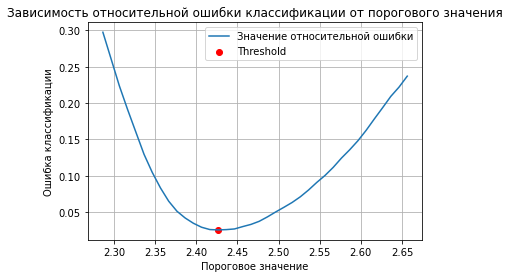

In [19]:
plt.scatter(thr_new, np.min(error_range), c="r", label='Threshold')
plt.plot(threshold_range, error_range, label='Значение относительной ошибки')
plt.title("Зависимость относительной ошибки классификации от порогового значения")
plt.xlabel("Пороговое значение")
plt.ylabel("Ошибка классификации")
plt.legend()
plt.grid()
plt.show()

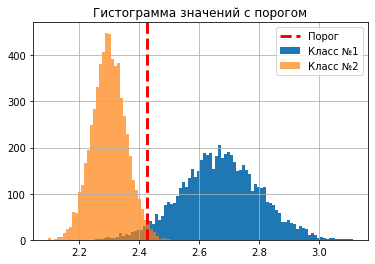

In [20]:
binwidth = 0.01
plt.hist(y1, bins=np.arange(min(y1), max(y1) + binwidth, binwidth), label='Класс №1', alpha=1.0)
plt.hist(y2, bins=np.arange(min(y2), max(y2) + binwidth, binwidth), label='Класс №2', alpha=0.7)
plt.axvline(thr_new, color='r', linestyle='dashed', linewidth=3, label='Порог')
plt.title("Гистограмма значений с порогом")
plt.legend()
plt.grid()
plt.show()

In [21]:
print("Ошибка на тренировочной выборке составила: %.4f" % np.min(error_range))

Ошибка на тренировочной выборке составила: 0.0254


__До сих пор был этап "обучения" модели__

## 1.4. Рассчитать относительную частоту ошибочной классификации при применении построенного классификатора к группе контроля.
Проекция тренирововочных данных

In [22]:
y1_test = a+b*test_data_1[:,0]
y2_test = a+b*test_data_2[:,0]

In [23]:
# Calculate histograms
y1_hist_test = np.histogram(y1_test, bins=np.arange(min(y1_test), max(y1_test) + binwidth, binwidth))
y2_hist_test = np.histogram(y2_test, bins=np.arange(min(y2_test), max(y2_test) + binwidth, binwidth))

In [24]:
error_test = count_rel_error(y1_hist_test, y2_hist_test, thr_new)

In [25]:
print("Ошибка на тестовой выборке составила: %.2f" % error_test)

Ошибка на тестовой выборке составила: 0.01


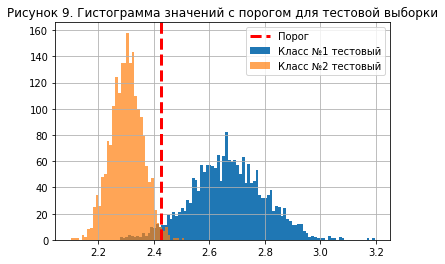

In [26]:
binwidth = 0.01
plt.hist(y1_test, bins=np.arange(min(y1_test), max(y1_test) + binwidth, binwidth), label='Класс №1 тестовый', alpha=1.0)
plt.hist(y2_test, bins=np.arange(min(y2_test), max(y2_test) + binwidth, binwidth), label='Класс №2 тестовый', alpha=0.7)
plt.axvline(thr_new, color='r', linestyle='dashed', linewidth=3, label='Порог')
plt.title("Рисунок 9. Гистограмма значений с порогом для тестовой выборки")
plt.legend()
plt.grid()
plt.show()

## 2. Оценка качества классификации
## 2.1. Сгенерировать два набора данных (по 1000 точек в каждом) как реализации двумерного нормального распределения. 
Первый набор данных: среднее значение равно [1; 3], СКО = [0,7; 0,8], коэффициент корреляции = 0,2.

In [27]:
N = 1000
cov_matrix_1 = np.array([[0.7**2, 0.2*0.7*0.8],
                         [0.2*0.7*0.8, 0.8**2]])
mean_value_1 = np.array([1, 3])
data_matrix_1 = np.random.multivariate_normal(mean_value_1, cov_matrix_1, size=N)

Второй набор данных: среднее значение равно [3;2], СКО = [0,3; 1,8], коэффициент корреляции = 0,7

In [28]:
cov_matrix_2 = np.array([[0.3**2, 0.7*0.3*1.8],
                         [0.7*0.3*1.8, 1.8**2]])
mean_value_2 = np.array([3, 2])
data_matrix_2 = np.random.multivariate_normal(mean_value_2, cov_matrix_2, size=N)

Разделение каждого класса на 10 подвыборок

In [29]:
class_1_batches = []
for i in range(10):
    class_1_batches.append(data_matrix_1[i*100:(i+1)*100])
    
class_2_batches = []
for i in range(10):
    class_2_batches.append(data_matrix_2[i*100:(i+1)*100])

Конкатенация данных

In [30]:
X_batches = []
for i in range(10):
    X_batches.append(np.concatenate((class_1_batches[i], class_2_batches[i]), axis=0))

Генерация меток класса

In [31]:
temp = np.zeros((200,))
temp[0:100] = 1
temp[100:200] = 2

y_batches = []
for i in range(10):
    y_batches.append(temp)

Перемешивание данных в каждой из десяти подвыборок

In [32]:
X_shuffled = []
y_shuffled = []
for i in range(10):
    x_b, y_b = shuffle(X_batches[i], y_batches[i], random_state=0)
    X_shuffled.append(x_b)
    y_shuffled.append(y_b)

Создание выборки для обучения из 9 подвыборок и выборки для тестирования из 1 подвыборки

In [33]:
X_train = np.reshape(np.array(X_shuffled[0:9]), (9*200, 2))
y_train = np.reshape(np.array(y_shuffled[0:9]), (9*200, ))

X_test = np.reshape(np.array(X_shuffled[9:10]), (1*200, 2))
y_test = np.reshape(np.array(y_shuffled[9:10]), (1*200, ))

Полный набор данных для кросс-валидации

In [34]:
X_cross_val = np.reshape(np.array(X_shuffled[:]), (10*200, 2))
y_cross_val = np.reshape(np.array(y_shuffled[:]), (10*200, ))

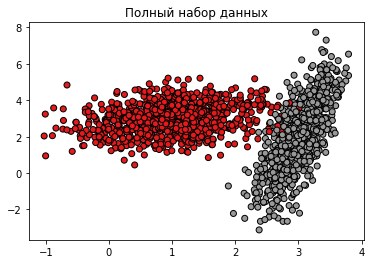

In [35]:
plt.scatter(X_cross_val[:, 0], X_cross_val[:, 1], c=y_cross_val, cmap="Set1", edgecolors='k')
plt.title("Полный набор данных")
plt.show()

## 2.2. Обзор классификаторов, реализуемых в пакете Scikit-learn
Напишем функцию для графического представления матрицы несоответствия

In [36]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax, cm

Напишем функцию для графического представления результатов классификации

In [37]:
def plot_classification_boundary(name, clf):
    """
    This function prints and plots the confusion matrix.
    """
    figure = plt.figure(figsize=(6, 6))
  
    h = .02  # step size in the mesh
    x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  
  
    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(1,1,1)
  
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k', alpha=0.2, label="Train")
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                     edgecolors='k', alpha=1, label="Test")
    ax.set_title(name)
    ax.legend()

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(xx.max() - .3, yy.min() + .3, ('Score = %.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
    plt.tight_layout()
    plt.show()

Применим линейный дискриминантный анализ

Модель 1. Линейный дискриминантный анализ
              precision    recall  f1-score   support

         1.0       1.00      0.96      0.98       100
         2.0       0.96      1.00      0.98       100

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200

[[ 96   4]
 [  0 100]]


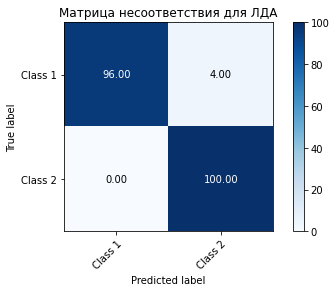

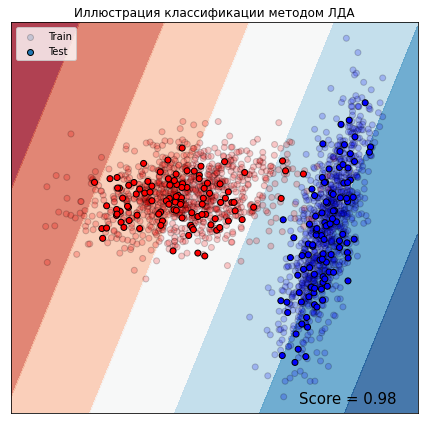

In [38]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
expected = y_test
predicted = clf.predict(X_test)

print("Модель 1. Линейный дискриминантный анализ")
print(metrics.classification_report(expected, predicted))
plot_confusion_matrix(expected, predicted, classes=np.array(["Class 1", "Class 2"]))
plt.title("Матрица несоответствия для ЛДА")
plt.plot()
plot_classification_boundary("Иллюстрация классификации методом ЛДА", clf)

Применим метод К-ближайших соседей с параметром k=3

Модель 2. Метод к-ближайших соседей
              precision    recall  f1-score   support

         1.0       0.98      1.00      0.99       100
         2.0       1.00      0.98      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

[[100   0]
 [  2  98]]


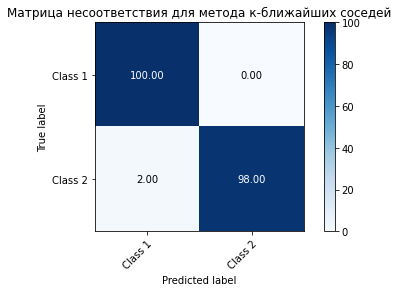

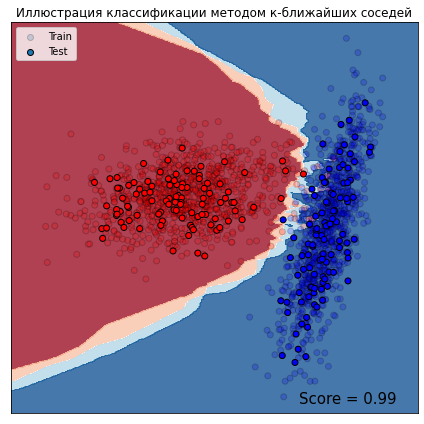

In [39]:
clf_1 = KNeighborsClassifier(3)
clf_1.fit(X_train, y_train)
expected_1 = y_test
predicted_1 = clf_1.predict(X_test)

print("Модель 2. Метод к-ближайших соседей")
print(metrics.classification_report(expected_1, predicted_1))
plot_confusion_matrix(expected_1, predicted_1, classes=np.array(["Class 1", "Class 2"]))
plt.title("Матрица несоответствия для метода к-ближайших соседей")
plt.plot()
plot_classification_boundary("Иллюстрация классификации методом к-ближайших соседей", clf_1)

Применим метод опорных векторов с линейным ядром

Модель 3. Метод опорных векторов
              precision    recall  f1-score   support

         1.0       1.00      0.98      0.99       100
         2.0       0.98      1.00      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

[[ 98   2]
 [  0 100]]


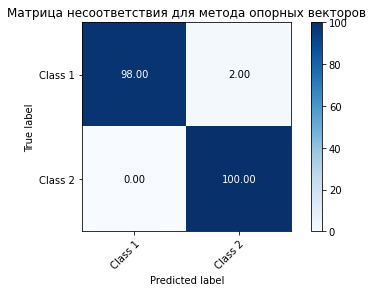

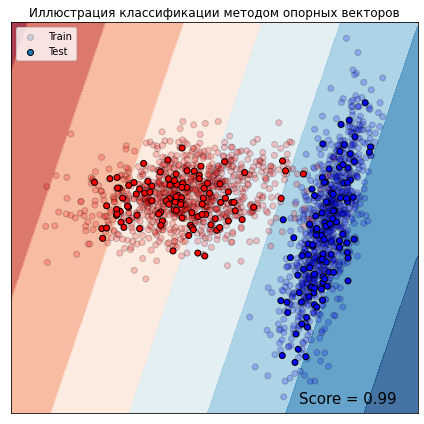

In [40]:
clf_2 = SVC(kernel="linear", C=0.025)
clf_2.fit(X_train, y_train)
expected_2 = y_test
predicted_2 = clf_2.predict(X_test)

print("Модель 3. Метод опорных векторов")
print(metrics.classification_report(expected_2, predicted_2))
plot_confusion_matrix(expected_2, predicted_2, classes=np.array(["Class 1", "Class 2"]))
plt.title("Матрица несоответствия для метода опорных векторов")
plt.plot()
plot_classification_boundary("Иллюстрация классификации методом опорных векторов", clf_2)

Применим метод решающего дерева

Модель 4. Решающее дерево
              precision    recall  f1-score   support

         1.0       0.98      0.98      0.98       100
         2.0       0.98      0.98      0.98       100

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200

[[98  2]
 [ 2 98]]


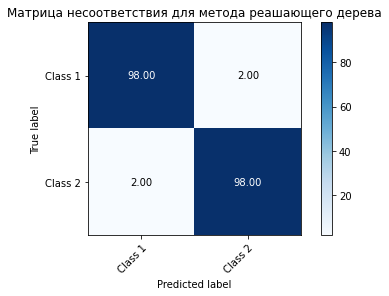

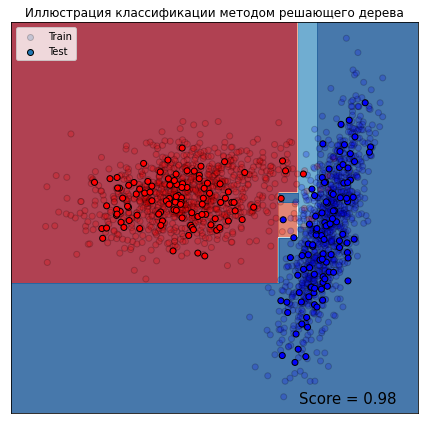

In [41]:
clf_3 = DecisionTreeClassifier(max_depth=5)
clf_3.fit(X_train, y_train)
expected_3 = y_test
predicted_3 = clf_3.predict(X_test)

print("Модель 4. Решающее дерево")
print(metrics.classification_report(expected_3, predicted_3))
plot_confusion_matrix(expected_3, predicted_3, classes=np.array(["Class 1", "Class 2"]))
plt.title("Матрица несоответствия для метода реашающего дерева")
plt.plot()
plot_classification_boundary("Иллюстрация классификации методом решающего дерева", clf_3)

## 2.3. Провести кросс-валидацию модели, оценить математическое ожидание ошибки и построить доверительный интервал
Для кросс-валидации выберем метод с наименьшей ошибкой классификации (или с наименьшим числом ошибок классификации). Выберем метод К-ближайших соседей с наибольшей точностью классификации и наименьшим числом ошибок.

In [42]:
clf_best = KNeighborsClassifier(3)
scores = cross_val_score(clf_best, X_cross_val, y_cross_val, cv=10)

Вероятность ошибки на каждой из 10 частей выборки составила:

In [43]:
1 - scores

array([0.015, 0.005, 0.005, 0.015, 0.01 , 0.01 , 0.015, 0.015, 0.025,
       0.01 ])

Среднее значение ошибки классификации составило:

In [44]:
mean_error = (1 - scores).mean()
mean_error

0.012500000000000011

Оценим общее число ошибок классификации на кажой из 10 частей выборки

[[983  17]
 [  8 992]]


[]

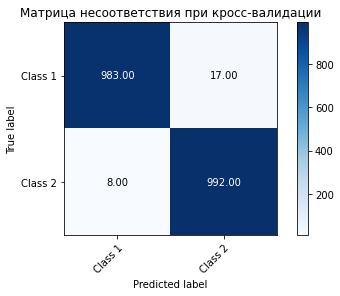

In [45]:
y_pred = cross_val_predict(clf_best, X_cross_val, y_cross_val, cv=10)
value = plot_confusion_matrix(y_cross_val, y_pred, classes=np.array(["Class 1", "Class 2"]))
plt.title("Матрица несоответствия при кросс-валидации")
plt.plot()

Следовательно, при общем числе классифицируемых объектов, равном 2000, число ошибок классификации составило:

In [46]:
num_samples = 2000
num_errors = value[1][0, 1] + value[1][1, 0]
num_errors

25

Определим довреительный интервал для матемтического ожидания ошибки с учетом значения c-квантиля распределения Фишера

In [47]:
def conf_interval(numerator, denominator_coef, quantile, df_1, df_2):
    return (1 + numerator/(denominator_coef*stats.f.ppf(quantile, df_1, df_2)))**(-1)

In [48]:
alpha = 0.95

In [49]:
left_lim = conf_interval(numerator=(num_samples-num_errors+1),
                         denominator_coef=num_errors,
                         quantile=(alpha/2),
                         df_1=(2*num_errors), 
                         df_2=(2*(num_samples-num_errors+1)))

right_lim = conf_interval(numerator=(num_samples-num_errors),
                          denominator_coef=(num_errors+1),
                          quantile=(1-alpha/2),
                          df_1=(2*(num_errors+1)), 
                          df_2=(2*(num_samples-num_errors)))

Таким образом, математическое ожидание ошибки классификации составляет:

In [50]:
print("%.4f"%mean_error)

0.0125


С доверительным интервалом:

In [51]:
print("[%.4f,%.4f]"%(left_lim, right_lim))

[0.0122,0.0130]


и уровнем доверия alpha = 0.95

# II. Методы машинного обучения в контексте компьютерного зрения
## 3. Сопоставление изображений с геометками
## 3.1. Функции для оценки SIFT-признаков
Для быстроты вычисления признаков воспользуемся прекомпилированной версией C-библиотеки VLFeat:
https://www.vlfeat.org

In [52]:
from PIL import Image, ImageDraw
from numpy import *
from pylab import *
import os
import pydot
from itertools import combinations
from scipy.cluster.vq import *

In [53]:
def process_image(imagename,resultname,params="--edge-thresh 10 --peak-thresh 5"):
    """ Process an image and save the results in a file. """

    if imagename[-3:] != 'pgm':
        # create a pgm file
        im = Image.open(imagename).convert('L')
        im.save('tmp.pgm')
        imagename = 'tmp.pgm'

    cmmd = str("sift "+imagename+" --output="+resultname+
                " "+params)
    os.system(cmmd)
    print('processed', imagename, 'to', resultname)


def read_features_from_file(filename):
    """ Read feature properties and return in matrix form. """
    
    f = loadtxt(filename)
    return f[:,:4],f[:,4:] # feature locations, descriptors


def write_features_to_file(filename,locs,desc):
    """ Save feature location and descriptor to file. """
    savetxt(filename,hstack((locs,desc)))
    

def plot_features(im,locs,circle=False):
    """ Show image with features. input: im (image as array), 
        locs (row, col, scale, orientation of each feature). """

    def draw_circle(c,r):
        t = arange(0,1.01,.01)*2*pi
        x = r*cos(t) + c[0]
        y = r*sin(t) + c[1]
        plot(x,y,'b',linewidth=2)

    imshow(im)
    if circle:
        for p in locs:
            draw_circle(p[:2],p[2]) 
    else:
        plot(locs[:,0],locs[:,1],'ob')
    axis('off')


def match(desc1,desc2):
    """ For each descriptor in the first image, 
        select its match in the second image.
        input: desc1 (descriptors for the first image), 
        desc2 (same for second image). """
    
    desc1 = array([d/linalg.norm(d) for d in desc1])
    desc2 = array([d/linalg.norm(d) for d in desc2])
    
    dist_ratio = 0.6
    desc1_size = desc1.shape
    
    matchscores = zeros((desc1_size[0]),'int')
    desc2t = desc2.T # precompute matrix transpose
    for i in range(desc1_size[0]):
        dotprods = dot(desc1[i,:],desc2t) # vector of dot products
        dotprods = 0.9999*dotprods
        # inverse cosine and sort, return index for features in second image
        indx = argsort(arccos(dotprods))
        
        # check if nearest neighbor has angle less than dist_ratio times 2nd
        if arccos(dotprods)[indx[0]] < dist_ratio * arccos(dotprods)[indx[1]]:
            matchscores[i] = int(indx[0])
    
    return matchscores


def appendimages(im1,im2):
    """ Return a new image that appends the two images side-by-side. """
    
    # select the image with the fewest rows and fill in enough empty rows
    rows1 = im1.shape[0]    
    rows2 = im2.shape[0]
    
    if rows1 < rows2:
        im1 = concatenate((im1,zeros((rows2-rows1,im1.shape[1]))), axis=0)
    elif rows1 > rows2:
        im2 = concatenate((im2,zeros((rows1-rows2,im2.shape[1]))), axis=0)
    # if none of these cases they are equal, no filling needed.
    
    return concatenate((im1,im2), axis=1)


def plot_matches(im1,im2,locs1,locs2,matchscores,show_below=True):
    """ Show a figure with lines joining the accepted matches
        input: im1,im2 (images as arrays), locs1,locs2 (location of features), 
        matchscores (as output from 'match'), show_below (if images should be shown below). """
    
    im3 = appendimages(im1,im2)
    if show_below:
        im3 = vstack((im3,im3))
    
    # show image
    imshow(im3)
    
    # draw lines for matches
    cols1 = im1.shape[1]
    for i,m in enumerate(matchscores):
        if m>0:
            plot([locs1[i][0],locs2[m][0]+cols1],[locs1[i][1],locs2[m][1]],'c')
    axis('off')


def match_twosided(desc1,desc2):
    """ Two-sided symmetric version of match(). """
    
    matches_12 = match(desc1,desc2)
    matches_21 = match(desc2,desc1)
    
    ndx_12 = matches_12.nonzero()[0]
    
    # remove matches that are not symmetric
    for n in ndx_12:
        if matches_21[int(matches_12[n])] != n:
            matches_12[n] = 0
    
    return matches_12

def get_imlist(path):
    """    Returns a list of filenames for 
        all images in a directory. """  
    return [os.path.join(path,f) for f in os.listdir(path)]

## 3.2. Считаем изображения

In [54]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return images

imlist = load_images_from_folder('landmarks/')

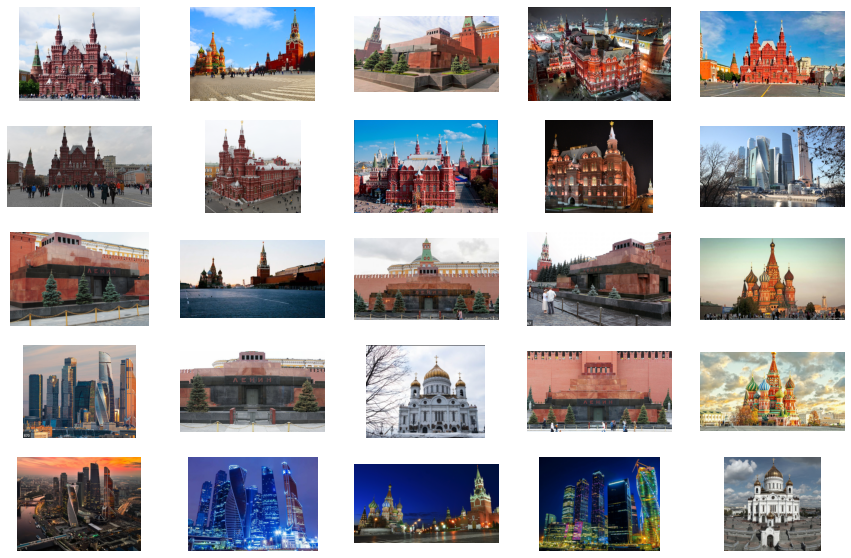

In [55]:
plt.figure(figsize=(15,10)) # specifying the overall grid size

imlist = imlist[1:]

for i in range(25):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.axis('off')
    plt.imshow(imlist[i])

plt.show()

In [57]:
download_path = "C:/Users/GeorgBell/OneDrive/Документы/Аспирантура/Computer_vision/Неделя_7/landmarks/" # set this to the path where you downloaded the panoramio images
path = "C:/Users/GeorgBell/OneDrive/Документы/Аспирантура/Computer_vision/Неделя_7/thumbs/" # path to save thumbnails (pydot needs the full system path)

# list of downloaded filenames
imlist = get_imlist(download_path)
nbr_images = len(imlist)

# extract features
featlist = [imname[:-3]+'sift' for imname in imlist]
for i,imname in enumerate(imlist):
    process_image(imname, featlist[i])

processed tmp.pgm to C:/Users/GeorgBell/OneDrive/Документы/Аспирантура/Computer_vision/Неделя_7/landmarks/0.sift
processed tmp.pgm to C:/Users/GeorgBell/OneDrive/Документы/Аспирантура/Computer_vision/Неделя_7/landmarks/1.sift
processed tmp.pgm to C:/Users/GeorgBell/OneDrive/Документы/Аспирантура/Computer_vision/Неделя_7/landmarks/10.sift
processed tmp.pgm to C:/Users/GeorgBell/OneDrive/Документы/Аспирантура/Computer_vision/Неделя_7/landmarks/11.sift
processed tmp.pgm to C:/Users/GeorgBell/OneDrive/Документы/Аспирантура/Computer_vision/Неделя_7/landmarks/12.sift
processed tmp.pgm to C:/Users/GeorgBell/OneDrive/Документы/Аспирантура/Computer_vision/Неделя_7/landmarks/13.sift
processed tmp.pgm to C:/Users/GeorgBell/OneDrive/Документы/Аспирантура/Computer_vision/Неделя_7/landmarks/14.sift
processed tmp.pgm to C:/Users/GeorgBell/OneDrive/Документы/Аспирантура/Computer_vision/Неделя_7/landmarks/15.sift
processed tmp.pgm to C:/Users/GeorgBell/OneDrive/Документы/Аспирантура/Computer_vision/Нед

## 3.3. Сопоставим локальные дескрипторы

In [58]:
matchscores = zeros((nbr_images,nbr_images))
      
for i in range(nbr_images):
    for j in range(i,nbr_images): # only compute upper triangle
        print(f'Comparing image {i} and {j}')
        l1,d1 = read_features_from_file(featlist[i]) 
        l2,d2 = read_features_from_file(featlist[j])
        matches = match_twosided(d1,d2)
        nbr_matches = sum(matches > 0)
        print('number of matches = ', nbr_matches)
        matchscores[i,j] = nbr_matches

# copy values
for i in range(nbr_images):
    for j in range(i+1,nbr_images): # no need to copy diagonal
        matchscores[j,i] = matchscores[i,j]

Comparing image 0 and 0
number of matches =  1691
Comparing image 0 and 1
number of matches =  0
Comparing image 0 and 2
number of matches =  0
Comparing image 0 and 3
number of matches =  1
Comparing image 0 and 4
number of matches =  0
Comparing image 0 and 5
number of matches =  0
Comparing image 0 and 6
number of matches =  0
Comparing image 0 and 7
number of matches =  2
Comparing image 0 and 8
number of matches =  0
Comparing image 0 and 9
number of matches =  2
Comparing image 0 and 10
number of matches =  0
Comparing image 0 and 11
number of matches =  1
Comparing image 0 and 12
number of matches =  0
Comparing image 0 and 13
number of matches =  0
Comparing image 0 and 14
number of matches =  0
Comparing image 0 and 15
number of matches =  0
Comparing image 0 and 16
number of matches =  0
Comparing image 0 and 17
number of matches =  0
Comparing image 0 and 18
number of matches =  0
Comparing image 0 and 19
number of matches =  0
Comparing image 0 and 20
number of matches =  0

number of matches =  0
Comparing image 5 and 12
number of matches =  0
Comparing image 5 and 13
number of matches =  0
Comparing image 5 and 14
number of matches =  0
Comparing image 5 and 15
number of matches =  0
Comparing image 5 and 16
number of matches =  0
Comparing image 5 and 17
number of matches =  0
Comparing image 5 and 18
number of matches =  0
Comparing image 5 and 19
number of matches =  0
Comparing image 5 and 20
number of matches =  0
Comparing image 5 and 21
number of matches =  0
Comparing image 5 and 22
number of matches =  0
Comparing image 5 and 23
number of matches =  1
Comparing image 5 and 24
number of matches =  0
Comparing image 5 and 25
number of matches =  0
Comparing image 5 and 26
number of matches =  0
Comparing image 5 and 27
number of matches =  0
Comparing image 5 and 28
number of matches =  0
Comparing image 5 and 29
number of matches =  0
Comparing image 5 and 30
number of matches =  0
Comparing image 5 and 31
number of matches =  1
Comparing image 5

number of matches =  0
Comparing image 11 and 23
number of matches =  0
Comparing image 11 and 24
number of matches =  0
Comparing image 11 and 25
number of matches =  0
Comparing image 11 and 26
number of matches =  0
Comparing image 11 and 27
number of matches =  0
Comparing image 11 and 28
number of matches =  0
Comparing image 11 and 29
number of matches =  0
Comparing image 11 and 30
number of matches =  1
Comparing image 11 and 31
number of matches =  0
Comparing image 11 and 32
number of matches =  0
Comparing image 11 and 33
number of matches =  0
Comparing image 11 and 34
number of matches =  0
Comparing image 12 and 12
number of matches =  362
Comparing image 12 and 13
number of matches =  0
Comparing image 12 and 14
number of matches =  7
Comparing image 12 and 15
number of matches =  4
Comparing image 12 and 16
number of matches =  0
Comparing image 12 and 17
number of matches =  0
Comparing image 12 and 18
number of matches =  1
Comparing image 12 and 19
number of matches 

number of matches =  0
Comparing image 19 and 34
number of matches =  0
Comparing image 20 and 20
number of matches =  1881
Comparing image 20 and 21
number of matches =  0
Comparing image 20 and 22
number of matches =  0
Comparing image 20 and 23
number of matches =  0
Comparing image 20 and 24
number of matches =  0
Comparing image 20 and 25
number of matches =  0
Comparing image 20 and 26
number of matches =  0
Comparing image 20 and 27
number of matches =  0
Comparing image 20 and 28
number of matches =  0
Comparing image 20 and 29
number of matches =  0
Comparing image 20 and 30
number of matches =  0
Comparing image 20 and 31
number of matches =  0
Comparing image 20 and 32
number of matches =  0
Comparing image 20 and 33
number of matches =  1
Comparing image 20 and 34
number of matches =  0
Comparing image 21 and 21
number of matches =  1299
Comparing image 21 and 22
number of matches =  0
Comparing image 21 and 23
number of matches =  0
Comparing image 21 and 24
number of matc

## 3.4. Построим граф для соотнесения изображений

In [59]:
def generate_graph(threshold, graph_name):
    g = pydot.Dot(graph_type='graph') # don’t want the default directed graph
    for i in range(nbr_images):
        for j in range(i+1,nbr_images):
            if matchscores[i,j] > threshold:
                #first image in pair
                im = Image.open(imlist[i])
                im.thumbnail((100,100))
                filename = str(i)+'.png'
                im.save(path+filename) # need temporary files of the right size
                g.add_node(pydot.Node(str(i),fontcolor='transparent',
                                      shape='rectangle',image=path+filename))
                # second image in pair
                im = Image.open(imlist[j])
                im.thumbnail((100,100))
                filename = str(j)+'.png'
                im.save(path+filename) # need temporary files of the right size
                g.add_node(pydot.Node(str(j),fontcolor='transparent',
                                      shape='rectangle',image=path+filename))
                g.add_edge(pydot.Edge(str(i),str(j)))            
    g.write_png(graph_name)

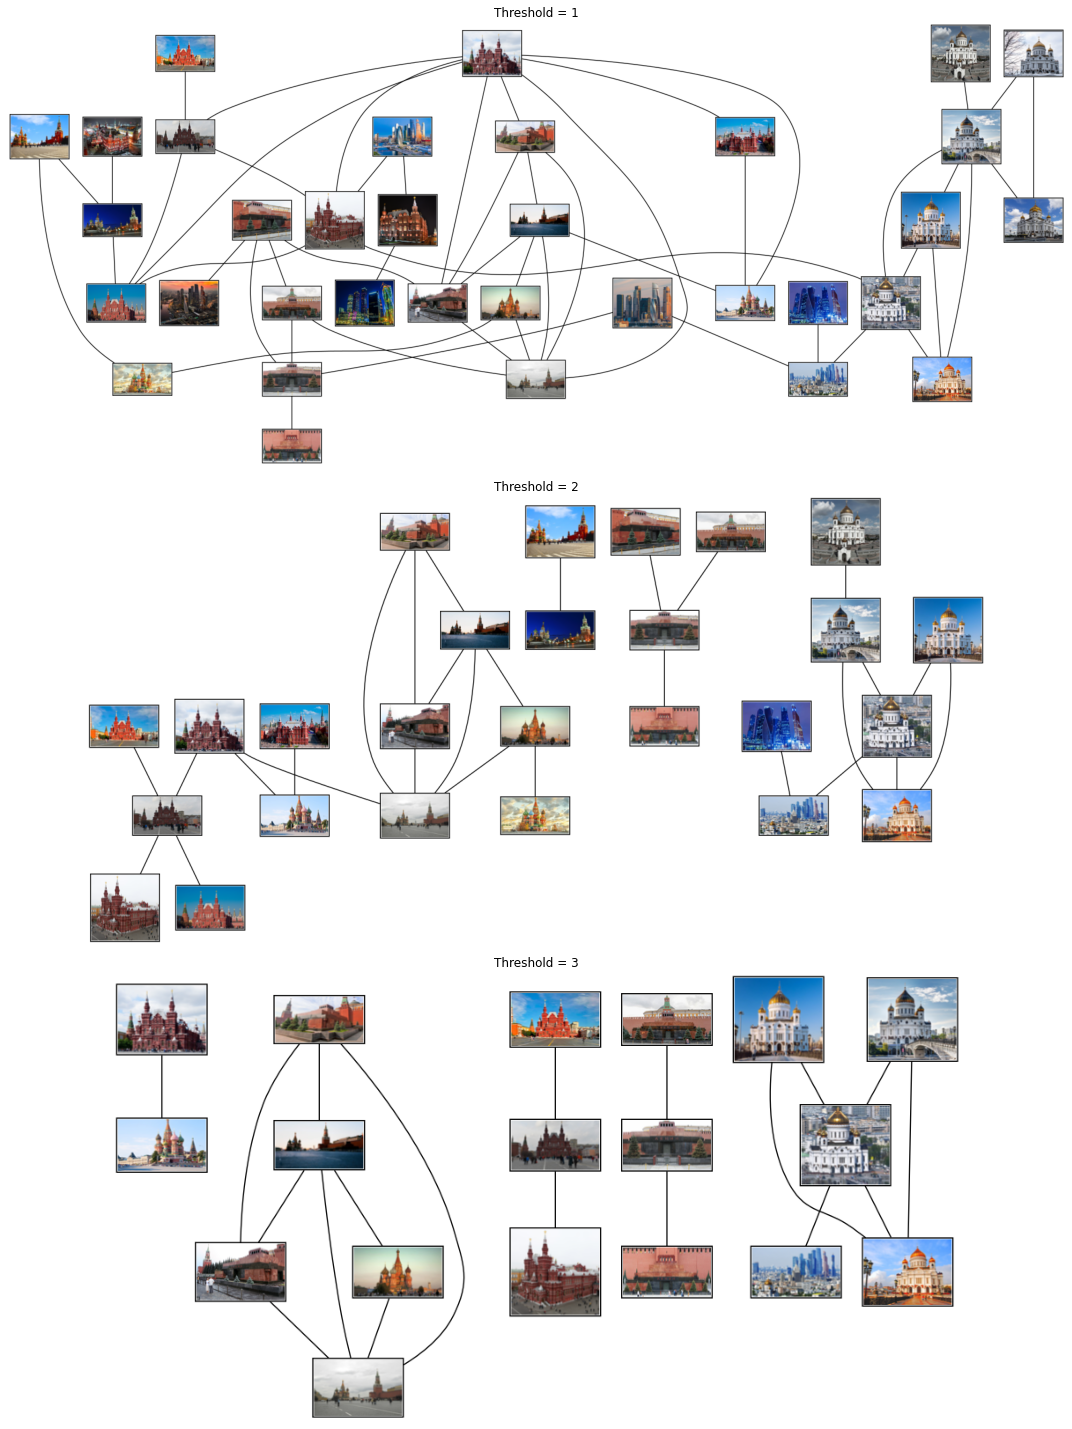

In [60]:
fig, axes = plt.subplots(3, 1, figsize=(15, 20))
ax = axes.ravel()

for i in range(1,4):
    name = f"graphs/graph_{i}.png"
    generate_graph(threshold=i, graph_name=name)
    
    ax[i-1].imshow(io.imread(name),)
    ax[i-1].set_title(f"Threshold = {i}")
    ax[i-1].axis('off')

fig.tight_layout()
plt.show()

## 4. Кластеризация изображений
## 4.1. Рассмотрим упрощенный 2D пример

In [61]:
class1 = 1.5 * randn(100,2)
class2 = randn(100,2) + array([5,5])
features = vstack((class1,class2))

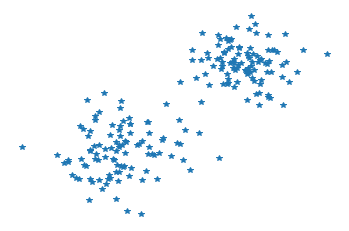

In [62]:
plt.figure()
plt.plot(features[:,0],features[:,1],'*')
plt.axis('off')
plt.show()

In [63]:
centroids,variance = kmeans(features,2)

In [64]:
code,distance = vq(features,centroids)

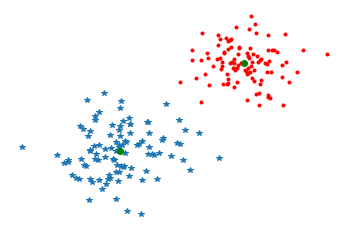

In [65]:
plt.figure()
ndx = where(code==0)[0]
plt.plot(features[ndx,0],features[ndx,1],'*')
ndx = where(code==1)[0]
plt.plot(features[ndx,0],features[ndx,1],'r.')
plt.plot(centroids[:,0],centroids[:,1],'go')
plt.axis('off')
plt.show()

## 4.2. Применим кластеризацию к изображениям
Для начала выполним снижение размерности путем применения анализа главных компонент

In [66]:
imlist = get_imlist('selected_fontimages/')

In [67]:
def pca(X):
    """ Principal Component Analysis
    input: X, matrix with training data stored as flattened arrays in rows
    return: projection matrix (with important dimensions first), variance and mean.
    """
    # get dimensions
    num_data,dim = X.shape
    # center data
    mean_X = X.mean(axis=0)
    X = X - mean_X
    if dim>num_data:
        # PCA - compact trick used
        M = dot(X,X.T) # covariance matrix
        e,EV = linalg.eigh(M) # eigenvalues and eigenvectors
        tmp = dot(X.T,EV).T # this is the compact trick
        V = tmp[::-1] # reverse since last eigenvectors are the ones we want
        S = sqrt(e)[::-1] # reverse since eigenvalues are in increasing order
        
        for i in range(V.shape[1]):
            V[:,i] /= S
    else:
        # PCA - SVD used
        U,S,V = linalg.svd(X)
        V = V[:num_data] # only makes sense to return the first num_data
        # return the projection matrix, the variance and the mean
    return V,S,mean_X

In [68]:
im = array(Image.open(imlist[0])) # open one image to get size
m,n = im.shape[0:2] # get the size of the images
imnbr = len(imlist) # get the number of images
# create matrix to store all flattened images
immatrix = array([array(Image.open(im)).flatten() for im in imlist],'f')

In [69]:
# perform PCA
V,S,immean = pca(immatrix)
# show some images (mean and 7 first modes)

<ipython-input-67-b2fd4e19c218>:17: RuntimeWarning: invalid value encountered in sqrt
  S = sqrt(e)[::-1] # reverse since eigenvalues are in increasing order


Визуализируем среднее изображение

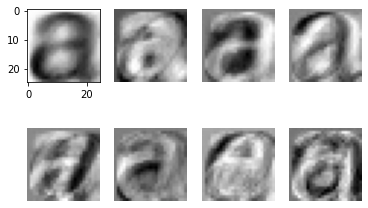

In [70]:
plt.figure()
plt.gray()
plt.subplot(2,4,1)
plt.imshow(immean.reshape(m,n))
for i in range(7):
    plt.subplot(2,4,i+2)
    plt.imshow(V[i].reshape(m,n))
    plt.axis("off")
plt.show()

Спроецируем данные на 40 главных компонент и применим кластериазацию

In [71]:
# project on the 40 first PCs
immean = immean.flatten()
projected = array([dot(V[:40],immatrix[i]-immean) for i in range(imnbr)])
# k-means
projected = whiten(projected)
centroids,distortion = kmeans(projected,4)
code,distance = vq(projected,centroids)

Размерность исходных и спроецированных данных

In [72]:
immatrix.shape

(66, 625)

In [73]:
projected.shape

(66, 40)

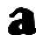

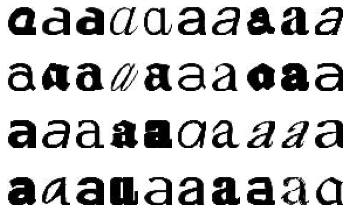

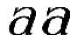

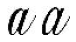

In [74]:
# plot clusters
for k in range(4):
    ind = where(code==k)[0]
    plt.figure()
    plt.gray()
    for i in range(minimum(len(ind),40)):
        plt.subplot(4,10,i+1)
        imshow(immatrix[ind[i]].reshape((25,25)))
        plt.axis('off')
plt.show()

## 4.3. Визуализируем на плоскости

In [79]:
projected = array([dot(V[[0,2]],immatrix[i]-immean) for i in range(imnbr)])

In [80]:
# height and width
h,w = 1200,1200
# create a new image with a white background
img = Image.new('RGB',(w,h),(255,255,255))
draw = ImageDraw.Draw(img)
# draw axis
draw.line((0,h/2,w,h/2),fill=(255,0,0))
draw.line((w/2,0,w/2,h),fill=(255,0,0))
# scale coordinates to fit
scale = abs(projected).max(0)
scaled = floor(array([ (p / scale) * (w/2-20,h/2-20) + (w/2,h/2) for p in projected]))
scaled = scaled.astype(int)
# paste thumbnail of each image

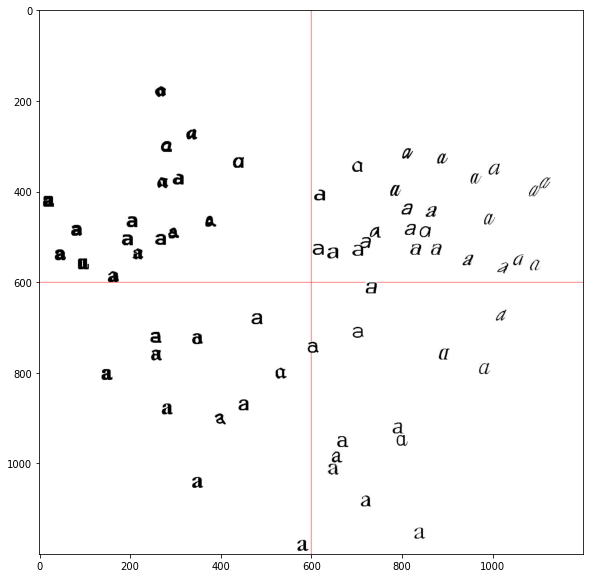

In [81]:
for i in range(imnbr):
    nodeim = Image.open(imlist[i])
    nodeim.thumbnail((25,25))
    ns = nodeim.size
    img.paste(nodeim,(scaled[i][0]-ns[0]//2,scaled[i][1]-
                      ns[1]//2,scaled[i][0]+ns[0]//2+1,scaled[i][1]+ns[1]//2+1))


plt.subplots(figsize=(10,10))
plt.imshow(img)
plt.show()

## 5. Иерархическая кластеризация

In [83]:
class ClusterNode(object):
    def __init__(self,vec,left,right,distance=0.0,count=1):
        self.left = left
        self.right = right
        self.vec = vec
        self.distance = distance
        self.count = count # only used for weighted average

    def extract_clusters(self,dist):
        """ Extract list of sub-tree clusters from 
            hcluster tree with distance<dist. """
        if self.distance < dist:
            return [self]
        return self.left.extract_clusters(dist) + self.right.extract_clusters(dist)

    def get_cluster_elements(self):
        """    Return ids for elements in a cluster sub-tree. """
        return self.left.get_cluster_elements() + self.right.get_cluster_elements()

    def get_height(self):
        """    Return the height of a node, 
            height is sum of each branch. """
        return self.left.get_height() + self.right.get_height()

    def get_depth(self):
        """    Return the depth of a node, depth is 
            max of each child plus own distance. """
        return max(self.left.get_depth(), self.right.get_depth()) + self.distance

    def draw(self,draw,x,y,s,imlist,im):
        """    Draw nodes recursively with image 
            thumbnails for leaf nodes. """
    
        h1 = int(self.left.get_height()*20 / 2)
        h2 = int(self.right.get_height()*20 /2)
        top = y-(h1+h2)
        bottom = y+(h1+h2)
        
        # vertical line to children    
        draw.line((x,top+h1,x,bottom-h2),fill=(0,0,0))    
        
        # horizontal lines 
        ll = self.distance*s
        draw.line((x,top+h1,x+ll,top+h1),fill=(0,0,0))    
        draw.line((x,bottom-h2,x+ll,bottom-h2),fill=(0,0,0))        
        
        # draw left and right child nodes recursively    
        self.left.draw(draw,x+ll,top+h1,s,imlist,im)
        self.right.draw(draw,x+ll,bottom-h2,s,imlist,im)
    

class ClusterLeafNode(object):
    def __init__(self,vec,id):
        self.vec = vec
        self.id = id

    def extract_clusters(self,dist):
        return [self] 

    def get_cluster_elements(self):
        return [self.id]

    def get_height(self):
        return 1

    def get_depth(self):
        return 0
    
    def draw(self,draw,x,y,s,imlist,im):
        nodeim = Image.open(imlist[self.id])
        nodeim.thumbnail([20,20])
        ns = nodeim.size
        im.paste(nodeim,[int(x),int(y-ns[1]//2),int(x+ns[0]),int(y+ns[1]-ns[1]//2)])


def L2dist(v1,v2):
    return sqrt(sum((v1-v2)**2))

    
def L1dist(v1,v2):
    return sum(abs(v1-v2))


def hcluster(features,distfcn=L2dist):
    """ Cluster the rows of features using 
        hierarchical clustering. """
    
    # cache of distance calculations
    distances = {}
    
    # initialize with each row as a cluster 
    node = [ClusterLeafNode(array(f),id=i) for i,f in enumerate(features)]
    
    while len(node)>1:
        closest = float('Inf')
        
        # loop through every pair looking for the smallest distance
        for ni,nj in combinations(node,2):
            if (ni,nj) not in distances: 
                distances[ni,nj] = distfcn(ni.vec,nj.vec)
                
            d = distances[ni,nj]
            if d<closest:
                closest = d 
                lowestpair = (ni,nj)
        ni,nj = lowestpair
        
        # average the two clusters
        new_vec = (ni.vec + nj.vec) / 2.0
        
        # create new node
        new_node = ClusterNode(new_vec,left=ni,right=nj,distance=closest)
        node.remove(ni)
        node.remove(nj)
        node.append(new_node)
    
    return node[0]


from PIL import Image,ImageDraw
 
def draw_dendrogram(node,imlist,filename='clusters.jpg'):
    """    Draw a cluster dendrogram and save to a file. """
    
    # height and width
    rows = node.get_height()*20
    cols = 1200
    
    # scale factor for distances to fit image width
    s = float(cols-150)/node.get_depth()
    
    # create image and draw object
    im = Image.new('RGB',(cols,rows),(255,255,255))
    draw = ImageDraw.Draw(im)
    
    # initial line for start of tree
    draw.line((0,rows/2,20,rows/2),fill=(0,0,0))    
    
    # draw the nodes recursively
    node.draw(draw,20,(rows/2),s,imlist,im)
    plt.subplots(figsize=(10,10))
    plt.imshow(im)
    plt.axis("off")
    plt.show()

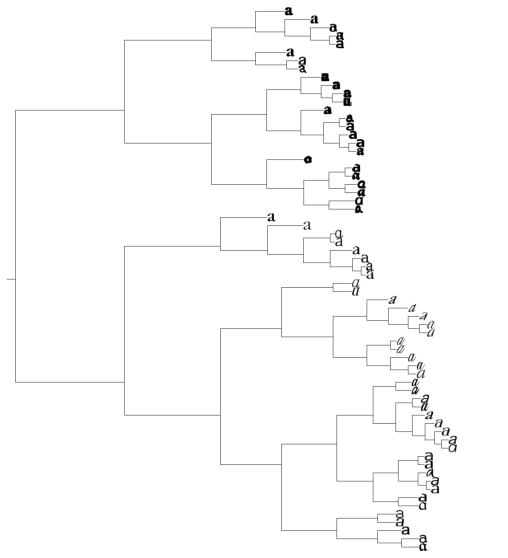

In [84]:
tree = hcluster(projected)
draw_dendrogram(tree,imlist,filename='fonts.jpg')

## 6. Применение баховых алгоритмов классификации
## 6.1. Генерация двумерных данных для упрощенного случая

In [85]:
from numpy.random import randn
import pickle

In [86]:
###
# Training data
###

# create sample data of 2D points
n = 200

# two normal distributions
class_1 = 0.6 * randn(n,2)
class_2 = 1.2 * randn(n,2) + array([5,1])
labels = hstack((ones(n),-ones(n)))

# save with Pickle
with open('data/points_normal.pkl', 'wb') as f:
    pickle.dump(class_1,f)
    pickle.dump(class_2,f)
    pickle.dump(labels,f)

# normal distribution and ring around it
class_1 = 0.6 * randn(n,2)
r = 0.8 * randn(n,1) + 5
angle = 2*pi * randn(n,1)
class_2 = hstack((r*cos(angle),r*sin(angle)))
labels = hstack((ones(n),-ones(n)))

# save with Pickle
with open('data/points_ring.pkl', 'wb') as f:
    pickle.dump(class_1,f)
    pickle.dump(class_2,f)
    pickle.dump(labels,f)


###
# Test data
###

# create sample data of 2D points
n = 200

# two normal distributions
class_1 = 0.6 * randn(n,2)
class_2 = 1.2 * randn(n,2) + array([5,1])
labels = hstack((ones(n),-ones(n)))

# save with Pickle
with open('data/points_normal_test.pkl', 'wb') as f:
    pickle.dump(class_1,f)
    pickle.dump(class_2,f)
    pickle.dump(labels,f)

# normal distribution and ring around it
class_1 = 0.6 * randn(n,2)
r = 0.8 * randn(n,1) + 5
angle = 2*pi * randn(n,1)
class_2 = hstack((r*cos(angle),r*sin(angle)))
labels = hstack((ones(n),-ones(n)))

# save with Pickle
with open('data/points_ring_test.pkl', 'wb') as f:
    pickle.dump(class_1,f)
    pickle.dump(class_2,f)
    pickle.dump(labels,f)

Вспомогательная функция для построения границ принятия решений

In [87]:
def plot_2D_boundary(plot_range,points,decisionfcn,labels,values=[0]):
    """    Plot_range is (xmin,xmax,ymin,ymax), points is a list
        of class points, decisionfcn is a funtion to evaluate, 
        labels is a list of labels that decisionfcn returns for each class, 
        values is a list of decision contours to show. """
        
    clist = ['b','r','g','k','m','y'] # colors for the classes
    
    # evaluate on a grid and plot contour of decision function
    x = arange(plot_range[0],plot_range[1],.1)
    y = arange(plot_range[2],plot_range[3],.1)
    xx,yy = meshgrid(x,y)
    xxx,yyy = xx.flatten(),yy.flatten() # lists of x,y in grid
    zz = array(decisionfcn(xxx,yyy)) 
    zz = zz.reshape(xx.shape)
    # plot contour(s) at values
    contour(xx,yy,zz,values) 
        
    # for each class, plot the points with '*' for correct, 'o' for incorrect
    for i in range(len(points)):
        d = decisionfcn(points[i][:,0],points[i][:,1])
        correct_ndx = labels[i]==d
        incorrect_ndx = labels[i]!=d
        plot(points[i][correct_ndx,0],points[i][correct_ndx,1],'*',color=clist[i])
        plot(points[i][incorrect_ndx,0],points[i][incorrect_ndx,1],'o',color=clist[i])
    
    axis('equal')

## 6.2. Создадим классификатор по К-ближайшим соседям и протестируем его на двумерных данных

In [88]:
class KnnClassifier(object):
    
    def __init__(self,labels,samples):
        """ Initialize classifier with training data. """
        
        self.labels = labels
        self.samples = samples
    
    def classify(self,point,k=3):
        """ Classify a point against k nearest 
            in the training data, return label. """
        
        # compute distance to all training points
        dist = array([L2dist(point,s) for s in self.samples])
        
        # sort them
        ndx = dist.argsort()
        
        # use dictionary to store the k nearest
        votes = {}
        for i in range(k):
            label = self.labels[ndx[i]]
            votes.setdefault(label,0)
            votes[label] += 1
            
        return max(votes)


def L2dist(p1,p2):
    return sqrt( sum( (p1-p2)**2) )

def L1dist(v1,v2):
    return sum(abs(v1-v2))

Протестируем на на двумерных нормальных данных

1.0


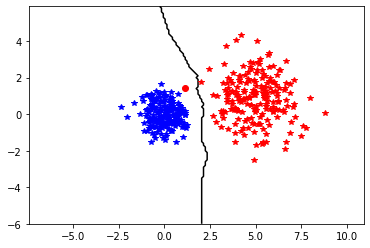

In [89]:
# load 2D points using Pickle
with open('data/points_normal.pkl', 'rb') as f:
    class_1 = pickle.load(f)
    class_2 = pickle.load(f)
    labels = pickle.load(f)

model = KnnClassifier(labels,vstack((class_1,class_2)))

# load test data using Pickle
with open('data/points_normal_test.pkl', 'rb') as f:
    class_1 = pickle.load(f)
    class_2 = pickle.load(f)
    labels = pickle.load(f)

# test on the first point
print(model.classify(class_1[0]))

# define function for plotting
def classify(x, y, model=model):
    return array([model.classify([xx,yy]) for (xx,yy) in zip(x,y)])

# plot the classification boundary
plot_2D_boundary([-6,6,-6,6], [class_1,class_2], classify, [1,-1])
show()

Протестируем на втором типе данных

1.0


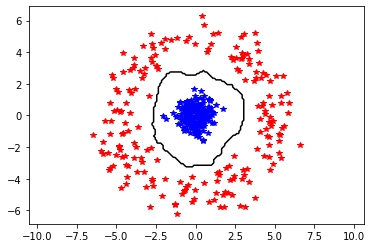

In [90]:
# load 2D points using Pickle
with open('data/points_ring.pkl', 'rb') as f:
    class_1 = pickle.load(f)
    class_2 = pickle.load(f)
    labels = pickle.load(f)

model = KnnClassifier(labels,vstack((class_1,class_2)))

# load test data using Pickle
with open('data/points_ring_test.pkl', 'rb') as f:
    class_1 = pickle.load(f)
    class_2 = pickle.load(f)
    labels = pickle.load(f)

# test on the first point
print(model.classify(class_1[0]))

# define function for plotting
def classify(x, y, model=model):
    return array([model.classify([xx,yy]) for (xx,yy) in zip(x,y)])

# plot the classification boundary
plot_2D_boundary([-6,6,-6,6], [class_1,class_2], classify, [1,-1])
show()

## 6.3. Создадим Байесовский классификатор и протестируем его на двумерных данных

In [91]:
class BayesClassifier(object):
    
    def __init__(self):
        """ Initialize classifier with training data. """
        
        self.labels = []    # class labels
        self.mean = []        # class mean
        self.var = []        # class variances
        self.n = 0            # nbr of classes
        
    def train(self,data,labels=None):
        """ Train on data (list of arrays n*dim). 
            Labels are optional, default is 0...n-1. """
        
        if labels==None:
            labels = range(len(data))
        self.labels = labels
        self.n = len(labels)
                
        for c in data:
            self.mean.append(mean(c,axis=0))
            self.var.append(var(c,axis=0))
        
    def classify(self,points):
        """ Classify the points by computing probabilities 
            for each class and return most probable label. """
        
        # compute probabilities for each class
        est_prob = array([gauss(m,v,points) for m,v in zip(self.mean,self.var)])
                
        print('est prob',est_prob.shape,self.labels)
        # get index of highest probability, this gives class label
        ndx = est_prob.argmax(axis=0)
        
        est_labels = array([self.labels[n] for n in ndx])
        
        return est_labels, est_prob


def gauss(m,v,x):
    """ Evaluate Gaussian in d-dimensions with independent 
        mean m and variance v at the points in (the rows of) x. 
        http://en.wikipedia.org/wiki/Multivariate_normal_distribution """
    
    if len(x.shape)==1:
        n,d = 1,x.shape[0]
    else:
        n,d = x.shape
            
    # covariance matrix, subtract mean
    S = diag(1/v)
    x = x-m
    # product of probabilities
    y = exp(-0.5*diag(dot(x,dot(S,x.T))))
    
    # normalize and return
    return y * (2*pi)**(-d/2.0) / ( sqrt(prod(v)) + 1e-6)

Протестируем на двумерных данных

est prob (2, 10) [1, -1]
[1 1 1 1 1 1 1 1 1 1]
est prob (2, 14400) [1, -1]
est prob (2, 200) [1, -1]
est prob (2, 200) [1, -1]


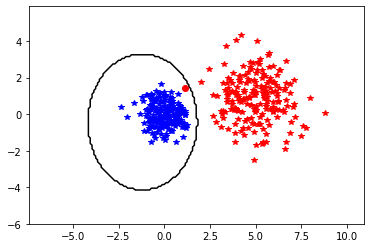

In [92]:
# load 2D points using Pickle
with open('data/points_normal.pkl', 'rb') as f:
    class_1 = pickle.load(f)
    class_2 = pickle.load(f)
    labels = pickle.load(f)

# train Bayes classifier
bc = BayesClassifier()
bc.train([class_1,class_2], [1,-1])

# load test data using Pickle
with open('data/points_normal_test.pkl', 'rb') as f:
    class_1 = pickle.load(f)
    class_2 = pickle.load(f)
    labels = pickle.load(f)

# test on the 10 first points
print(bc.classify(class_1[:10])[0])

# define function for plotting
def classify(x, y, bc=bc):
    points = vstack((x,y))
    return bc.classify(points.T)[0]

# plot the classification boundary
plot_2D_boundary([-6,6,-6,6], [class_1,class_2], classify, [1,-1])
show()

est prob (2, 10) [1, -1]
[ 1  1  1  1 -1  1 -1  1  1  1]
est prob (2, 14400) [1, -1]
est prob (2, 200) [1, -1]
est prob (2, 200) [1, -1]


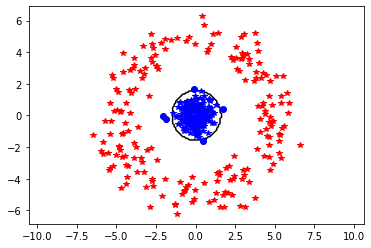

In [93]:
# load 2D points using Pickle
with open('data/points_ring.pkl', 'rb') as f:
    class_1 = pickle.load(f)
    class_2 = pickle.load(f)
    labels = pickle.load(f)

# train Bayes classifier
bc = BayesClassifier()
bc.train([class_1,class_2], [1,-1])

# load test data using Pickle
with open('data/points_ring_test.pkl', 'rb') as f:
    class_1 = pickle.load(f)
    class_2 = pickle.load(f)
    labels = pickle.load(f)

# test on the 10 first points
print(bc.classify(class_1[:10])[0])

# define function for plotting
def classify(x, y, bc=bc):
    points = vstack((x,y))
    return bc.classify(points.T)[0]

# plot the classification boundary
plot_2D_boundary([-6,6,-6,6], [class_1,class_2], classify, [1,-1])
show()

## 6.4. Подготовим датасет изображений языка жестов

In [94]:
def process_image_dsift(imagename,resultname,size=20,steps=10,force_orientation=False,resize=None):
    """ Process an image with densely sampled SIFT descriptors 
        and save the results in a file. Optional input: size of features, 
        steps between locations, forcing computation of descriptor orientation 
        (False means all are oriented upwards), tuple for resizing the image."""

    im = Image.open(imagename).convert('L')
    if resize!=None:
        im = im.resize(resize)
    m,n = im.size
    
    if imagename[-3:] != 'pgm':
        #create a pgm file
        im.save('tmp.pgm')
        imagename = 'tmp.pgm'

    # create frames and save to temporary file
    scale = size/3.0
    x,y = meshgrid(range(steps,m,steps),range(steps,n,steps))
    xx,yy = x.flatten(),y.flatten()
    frame = array([xx,yy,scale*ones(xx.shape[0]),zeros(xx.shape[0])])
    savetxt('tmp.frame',frame.T,fmt='%03.3f')
    
    if force_orientation:
        cmmd = str("sift "+imagename+" --output="+resultname+
                    " --read-frames=tmp.frame --orientations")
    else:
        cmmd = str("sift "+imagename+" --output="+resultname+
                    " --read-frames=tmp.frame")
    os.system(cmmd)
    print('processed', imagename, 'to', resultname)

Выделим SIFT-признаки

In [95]:
path = 'data/hand_gesture/test/'
imlist = []
for filename in os.listdir(path):
    if os.path.splitext(filename)[1] == '.ppm':
        imlist.append(path+filename)


# process images at fixed size (50,50)
for filename in imlist:
    featfile = filename[:-3]+'dsift'
    process_image_dsift(filename, featfile, 10, 5, resize=(50,50))

processed tmp.pgm to data/hand_gesture/test/A-uniform30.dsift
processed tmp.pgm to data/hand_gesture/test/A-uniform31.dsift
processed tmp.pgm to data/hand_gesture/test/A-uniform32.dsift
processed tmp.pgm to data/hand_gesture/test/A-uniform33.dsift
processed tmp.pgm to data/hand_gesture/test/A-uniform34.dsift
processed tmp.pgm to data/hand_gesture/test/A-uniform35.dsift
processed tmp.pgm to data/hand_gesture/test/A-uniform36.dsift
processed tmp.pgm to data/hand_gesture/test/A-uniform37.dsift
processed tmp.pgm to data/hand_gesture/test/A-uniform38.dsift
processed tmp.pgm to data/hand_gesture/test/A-uniform39.dsift
processed tmp.pgm to data/hand_gesture/test/A-uniform40.dsift
processed tmp.pgm to data/hand_gesture/test/A-uniform41.dsift
processed tmp.pgm to data/hand_gesture/test/A-uniform42.dsift
processed tmp.pgm to data/hand_gesture/test/A-uniform43.dsift
processed tmp.pgm to data/hand_gesture/test/A-uniform44.dsift
processed tmp.pgm to data/hand_gesture/test/A-uniform45.dsift
processe

processed tmp.pgm to data/hand_gesture/test/Point-uniform42.dsift
processed tmp.pgm to data/hand_gesture/test/Point-uniform43.dsift
processed tmp.pgm to data/hand_gesture/test/Point-uniform44.dsift
processed tmp.pgm to data/hand_gesture/test/Point-uniform45.dsift
processed tmp.pgm to data/hand_gesture/test/Point-uniform46.dsift
processed tmp.pgm to data/hand_gesture/test/Point-uniform47.dsift
processed tmp.pgm to data/hand_gesture/test/Point-uniform48.dsift
processed tmp.pgm to data/hand_gesture/test/Point-uniform49.dsift
processed tmp.pgm to data/hand_gesture/test/Point-uniform50.dsift
processed tmp.pgm to data/hand_gesture/test/Point-uniform51.dsift
processed tmp.pgm to data/hand_gesture/test/Point-uniform52.dsift
processed tmp.pgm to data/hand_gesture/test/Point-uniform53.dsift
processed tmp.pgm to data/hand_gesture/test/Point-uniform54.dsift
processed tmp.pgm to data/hand_gesture/test/Point-uniform55.dsift
processed tmp.pgm to data/hand_gesture/test/Point-uniform56.dsift
processed 

In [96]:
path = 'data/hand_gesture/train/'
imlist = []
for filename in os.listdir(path):
    if os.path.splitext(filename)[1] == '.ppm':
        imlist.append(path+filename)


# process images at fixed size (50,50)
for filename in imlist:
    featfile = filename[:-3]+'dsift'
    process_image_dsift(filename, featfile, 10, 5, resize=(50,50))
    print(featfile)

processed tmp.pgm to data/hand_gesture/train/A-uniform01.dsift
data/hand_gesture/train/A-uniform01.dsift
processed tmp.pgm to data/hand_gesture/train/A-uniform02.dsift
data/hand_gesture/train/A-uniform02.dsift
processed tmp.pgm to data/hand_gesture/train/A-uniform03.dsift
data/hand_gesture/train/A-uniform03.dsift
processed tmp.pgm to data/hand_gesture/train/A-uniform04.dsift
data/hand_gesture/train/A-uniform04.dsift
processed tmp.pgm to data/hand_gesture/train/A-uniform05.dsift
data/hand_gesture/train/A-uniform05.dsift
processed tmp.pgm to data/hand_gesture/train/A-uniform06.dsift
data/hand_gesture/train/A-uniform06.dsift
processed tmp.pgm to data/hand_gesture/train/A-uniform07.dsift
data/hand_gesture/train/A-uniform07.dsift
processed tmp.pgm to data/hand_gesture/train/A-uniform08.dsift
data/hand_gesture/train/A-uniform08.dsift
processed tmp.pgm to data/hand_gesture/train/A-uniform09.dsift
data/hand_gesture/train/A-uniform09.dsift
processed tmp.pgm to data/hand_gesture/train/A-uniform1

processed tmp.pgm to data/hand_gesture/train/C-uniform20.dsift
data/hand_gesture/train/C-uniform20.dsift
processed tmp.pgm to data/hand_gesture/train/C-uniform21.dsift
data/hand_gesture/train/C-uniform21.dsift
processed tmp.pgm to data/hand_gesture/train/C-uniform22.dsift
data/hand_gesture/train/C-uniform22.dsift
processed tmp.pgm to data/hand_gesture/train/C-uniform23.dsift
data/hand_gesture/train/C-uniform23.dsift
processed tmp.pgm to data/hand_gesture/train/C-uniform24.dsift
data/hand_gesture/train/C-uniform24.dsift
processed tmp.pgm to data/hand_gesture/train/C-uniform25.dsift
data/hand_gesture/train/C-uniform25.dsift
processed tmp.pgm to data/hand_gesture/train/C-uniform26.dsift
data/hand_gesture/train/C-uniform26.dsift
processed tmp.pgm to data/hand_gesture/train/C-uniform27.dsift
data/hand_gesture/train/C-uniform27.dsift
processed tmp.pgm to data/hand_gesture/train/C-uniform28.dsift
data/hand_gesture/train/C-uniform28.dsift
processed tmp.pgm to data/hand_gesture/train/C-uniform2

processed tmp.pgm to data/hand_gesture/train/Point-uniform28.dsift
data/hand_gesture/train/Point-uniform28.dsift
processed tmp.pgm to data/hand_gesture/train/Point-uniform29.dsift
data/hand_gesture/train/Point-uniform29.dsift
processed tmp.pgm to data/hand_gesture/train/Point-uniform30.dsift
data/hand_gesture/train/Point-uniform30.dsift
processed tmp.pgm to data/hand_gesture/train/Point-uniform31.dsift
data/hand_gesture/train/Point-uniform31.dsift
processed tmp.pgm to data/hand_gesture/train/Point-uniform32.dsift
data/hand_gesture/train/Point-uniform32.dsift
processed tmp.pgm to data/hand_gesture/train/Point-uniform33.dsift
data/hand_gesture/train/Point-uniform33.dsift
processed tmp.pgm to data/hand_gesture/train/Point-uniform34.dsift
data/hand_gesture/train/Point-uniform34.dsift
processed tmp.pgm to data/hand_gesture/train/Point-uniform35.dsift
data/hand_gesture/train/Point-uniform35.dsift
processed tmp.pgm to data/hand_gesture/train/Point-uniform36.dsift
data/hand_gesture/train/Point

(50, 50, 3)


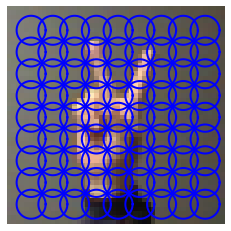

In [99]:
# show an image with features
l,d = read_features_from_file(featfile)
im = array(Image.open(filename).resize((50,50)))
print(im.shape)

figure()
plot_features(im, l, True)
show()

Вспомогательные функции

In [100]:
def read_gesture_features_labels(path):
    # create list of all files ending in .dsift
    featlist = [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.dsift')]

    # read the features
    features = []
    for featfile in featlist:
        l,d = read_features_from_file(featfile)
        features.append(d.flatten())
    features = array(features)

    # create labels
    labels = [featfile.split('/')[-1][0] for featfile in featlist]

    return features,array(labels)


def convert_labels(labels,transl):
    """ Convert between strings and numbers. """
    return [transl[l] for l in labels]


def print_confusion(res,labels,classnames):

    n = len(classnames)

    # confusion matrix
    class_ind = dict([(classnames[i],i) for i in range(n)])

    confuse = zeros((n,n))
    for i in range(len(test_labels)):
        confuse[class_ind[res[i]],class_ind[test_labels[i]]] += 1

    print('Confusion matrix for')
    print(classnames)
    print(confuse)

Считаем выделенные признаки

In [101]:
# read training data
####################
features,labels = read_gesture_features_labels('data/hand_gesture/train/')
print ('training data is:', features.shape, len(labels))

# read test data
####################
test_features,test_labels = read_gesture_features_labels('data/hand_gesture/test/')
print ('test data is:', test_features.shape, len(test_labels))

classnames = unique(labels)
nbr_classes = len(classnames)

training data is: (196, 10368) 196
test data is: (186, 10368) 186


Снизим размерность данных

In [102]:
# reduce dimensions with PCA
V,S,m = pca(features)

# keep most important dimensions
V = V[:50]
features = array([dot(V,f-m) for f in features])
test_features = array([dot(V,f-m) for f in test_features])

## 6.5. Протестируем метод K-ближайших соседей

In [103]:
k = 1
knn_classifier = KnnClassifier(labels,features)
res = array([knn_classifier.classify(test_features[i],k) for i in range(len(test_labels))])

# accuracy
acc = sum(1.0*(res==test_labels)) / len(test_labels)
print('Accuracy:', acc)

print_confusion(res,test_labels,classnames)

Accuracy: 0.8225806451612904
Confusion matrix for
['A' 'B' 'C' 'F' 'P' 'V']
[[24.  0.  2.  0.  0.  1.]
 [ 0. 25.  2.  2.  0.  0.]
 [ 0.  0. 25.  0.  0.  0.]
 [ 0.  3.  0. 36.  0.  0.]
 [ 1.  1.  4.  0. 20.  5.]
 [ 4.  1.  0.  0.  7. 23.]]


## Задание
1. Применить метод K-ближайших соседей к "сырым" исходным изображениям и сравнить результаты с тем, что получено при извлечении признаков и снижении разерности.
2. Применить к выделенным DSIFT признакам несколько различных классификаторов из библиотеки Scikit-Learn, опредилить наилучший результат классификации.